In [1]:
import sys
sys.path.append("../")
    
def moving_average(l, n=10):
    cumsum, moving_aves = [0], []
    for i, x in enumerate(l, 1):
        cumsum.append(cumsum[i-1] + x)
        if i>=n:
            moving_ave = (cumsum[i] - cumsum[i-n])/n
            moving_aves.append(moving_ave)
    return moving_aves

In [2]:
meta_train_train_loss, meta_train_valid_loss = [], []
meta_train_train_acc, meta_train_valid_acc = [], []
meta_valid_train_loss, meta_valid_valid_loss = [], []
meta_valid_train_acc, meta_valid_valid_acc = [], []

meta_train_loss_ratio = []
meta_train_acc_ratio = []
meta_valid_loss_ratio = []
meta_valid_acc_ratio = []


for meta in open('../log/meta_training_history.txt'): 
    meta = meta.split()
    title = meta[0]
    meta_results = meta[1].split(',')
    if title == "META_TRAIN_TRAIN:":
        meta_train_train_loss.append(float(meta_results[0]))
        meta_train_train_acc.append(float(meta_results[1]))
    elif title == "META_TRAIN_VALID:":
        meta_train_valid_loss.append(float(meta_results[0]))
        meta_train_valid_acc.append(float(meta_results[1]))
    elif title == "META_VALID_TRAIN:": 
        meta_valid_train_loss.append(float(meta_results[0]))
        meta_valid_train_acc.append(float(meta_results[1]))
    elif title == "META_VALID_VALID:":
        meta_valid_valid_loss.append(float(meta_results[0]))
        meta_valid_valid_acc.append(float(meta_results[1]))
    elif title == "META_TRAIN_RATIO:":
        meta_train_loss_ratio.append(float(meta_results[0]))
        meta_train_acc_ratio.append(float(meta_results[1]))
    elif title == "META_VALID_RATIO:": 
        meta_valid_loss_ratio.append(float(meta_results[0]))
        meta_valid_acc_ratio.append(float(meta_results[1]))
        
avg_n = 8

meta_train_train_loss = moving_average(meta_train_train_loss, n=avg_n)
meta_train_valid_loss = moving_average(meta_train_valid_loss, n=avg_n)
meta_train_train_acc = moving_average(meta_train_train_acc, n=avg_n)
meta_train_valid_acc = moving_average(meta_train_valid_acc, n=avg_n)
meta_train_loss_ratio = moving_average(meta_train_loss_ratio, n=avg_n)
meta_train_acc_ratio = moving_average(meta_train_acc_ratio, n=avg_n)

TRAINING CONFIGURATION:
backpropagation_depth: 32
backpropagation_padding: 4
classes_per_learner_set: 2
continue_task: True
dataset_key: cifar100
debug_mode: False
hidden_state_size: 20
initial_lr: 0.015
learner_batch_size: 32
learner_test_size: 96
learner_train_size: 32
logging_level: info
lr_schedule: [(0, 0.001)]
meta_batch_size: 8
meta_early_stopping: 256
meta_test_class_ratio: 0.3
n_learner_batches: 64
n_meta_epochs: 256
n_meta_valid_steps: 64
n_test_sets: 64
n_train_sets: 64



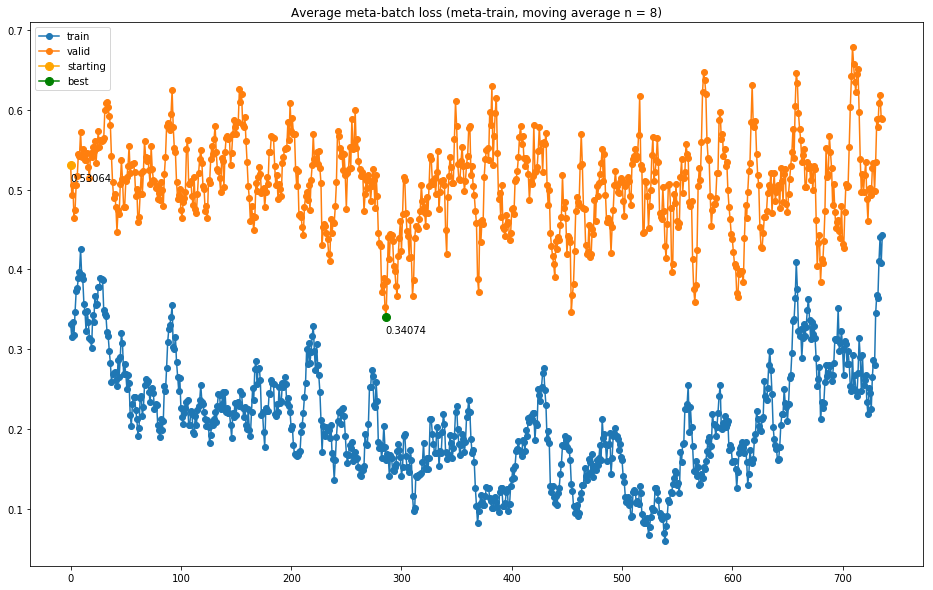

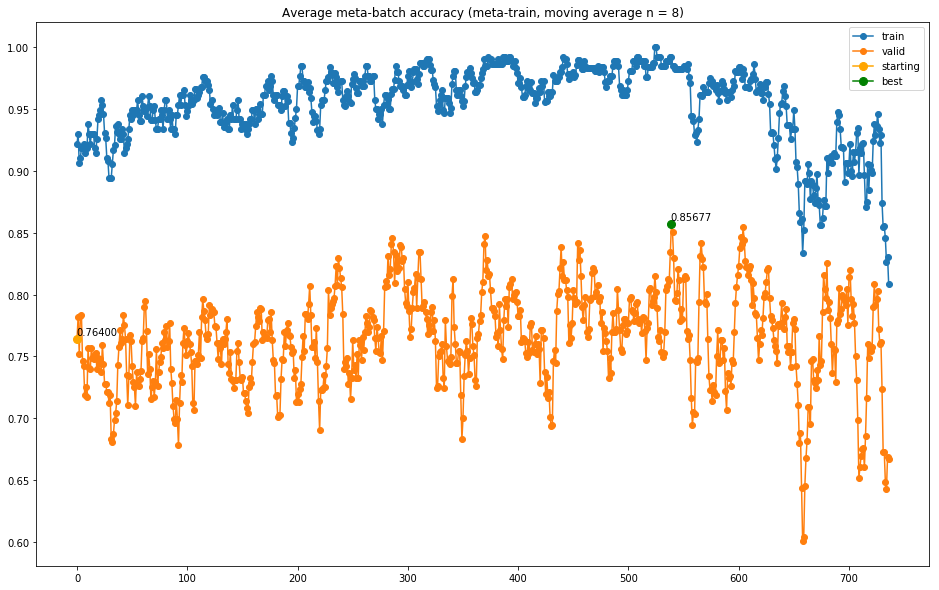

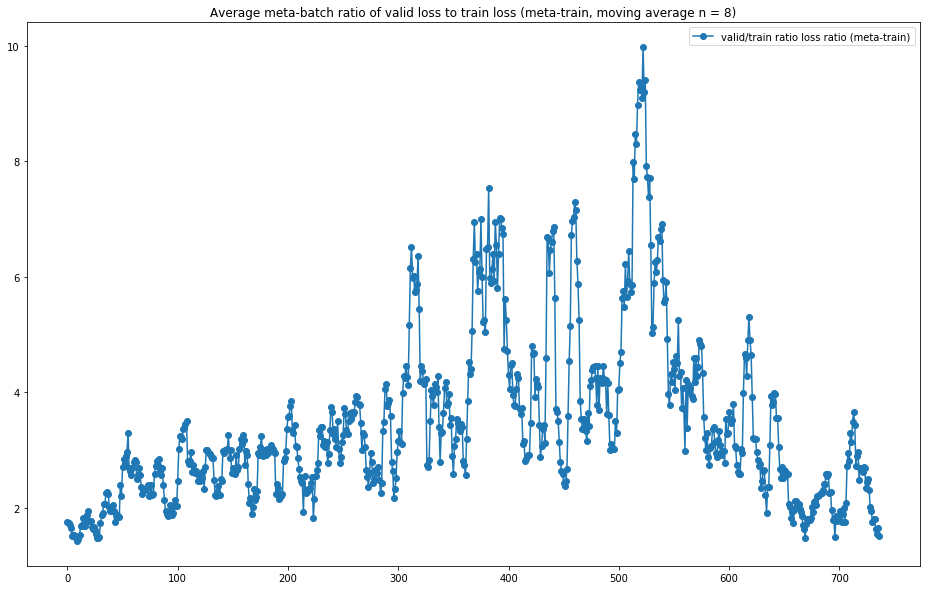

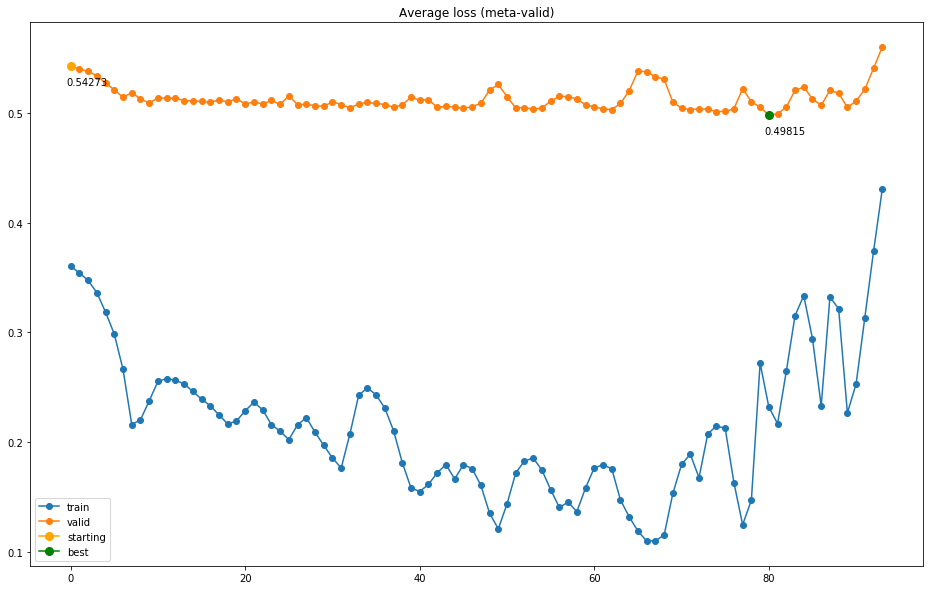

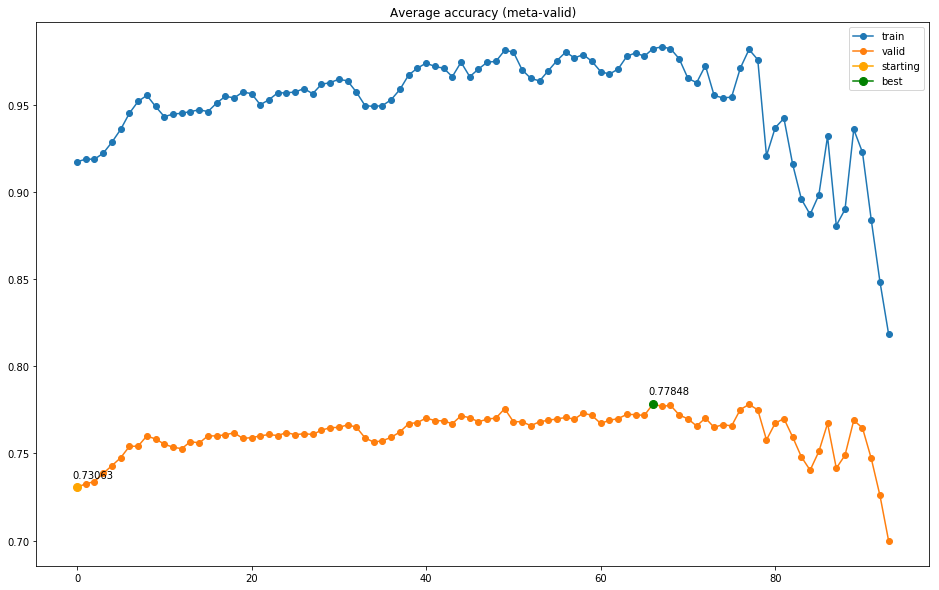

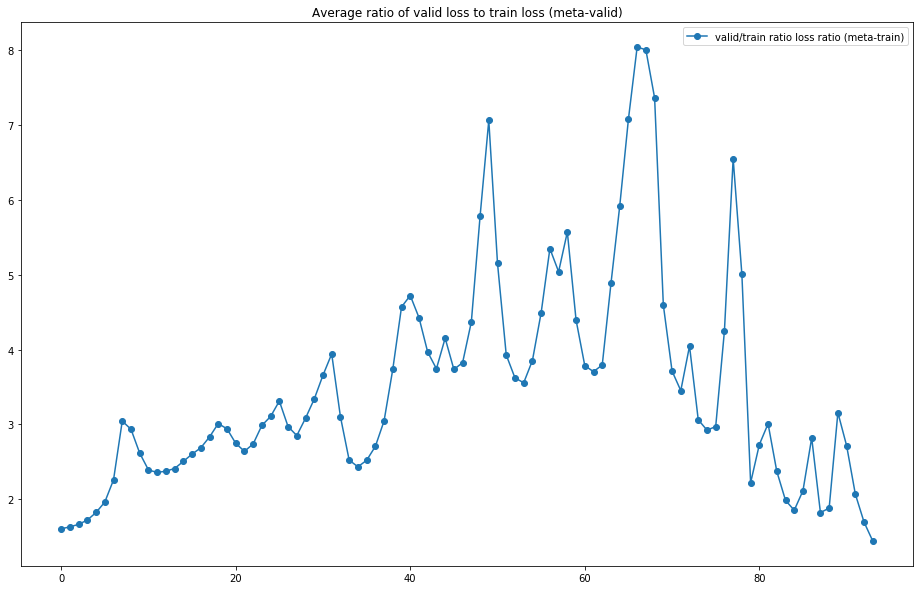

In [4]:
import matplotlib.pyplot as plt

training_conf_log = []
i = 0
for line in open('../log/train-meta-model.log'):
    if line.startswith('2018'):
        if i == 0 : i += 1
        else: break
    else:
        training_conf_log.append(line)

print('TRAINING CONFIGURATION:')
print(''.join(training_conf_log))

plt.rcParams["figure.figsize"] = (16,10)


def draw_figure(train_data, valid_data, title, min_fun = None, train_label='train', valid_label='valid'):
    train, = plt.plot(train_data, '-o', label=train_label)
    legend_handles = [train]
    if valid_data is not None:
        valid, = plt.plot(valid_data, '-o', label=valid_label)
        legend_handles.append(valid)
    if valid_data is not None and min_fun is not None:
        shift = 0.01
        if min_fun is min:
            shift *= -1
        begin_handle, = plt.plot([0], [valid_data[0]], marker='o', markersize=8, color="orange", label='starting')
        ax = plt.gca()
        ax.annotate('{:.5f}'.format(valid_data[0]), xy=(0, valid_data[0]), xytext=(-0.5, valid_data[0] + shift), 
                    horizontalalignment='left', verticalalignment='top')
        
        
        best = min_fun(valid_data)
        best_ind = valid_data.index(best)
        best_handle, = plt.plot([best_ind], [best], marker='o', markersize=8, color="green", label='best')
        ax = plt.gca()
        ax.annotate('{:.5f}'.format(best), xy=(best_ind, best), xytext=(best_ind - 0.5, best + shift), 
                    horizontalalignment='left', verticalalignment='top')
        
        legend_handles += [begin_handle, best_handle]

    plt.legend(handles=legend_handles)
    plt.title(title)
    plt.show()    

    
draw_figure(meta_train_train_loss, meta_train_valid_loss,
           "Average meta-batch loss (meta-train, moving average n = {})".format(avg_n), min)

draw_figure(meta_train_train_acc, meta_train_valid_acc,
           "Average meta-batch accuracy (meta-train, moving average n = {})".format(avg_n), max)

draw_figure(meta_train_loss_ratio, None,
           "Average meta-batch ratio of valid loss to train loss (meta-train, moving average n = {})".format(avg_n),
           train_label='valid/train ratio loss ratio (meta-train)')

draw_figure(meta_valid_train_loss, meta_valid_valid_loss, "Average loss (meta-valid)", min)

draw_figure(meta_valid_train_acc, meta_valid_valid_acc, "Average accuracy (meta-valid)", max)

draw_figure(meta_valid_loss_ratio, None,
           "Average ratio of valid loss to train loss (meta-valid)".format(avg_n),
           train_label='valid/train ratio loss ratio (meta-train)')

In [5]:
# Prepare data for comparison of meta-optimizer with SGD and Adam

import os
from src.datasets.cifar import load_cifar100, cifar_input_shape
from src.datasets.metadataset import load_meta_dataset

from src.training.training_configuration import read_configuration
from src.model.learner.simple_cnn import build_simple_cnn
from keras.optimizers import SGD

train_conf_path = os.path.join(os.environ['CONF_DIR'], 'training_configuration.yml')
conf = read_configuration(train_conf_path)

X_train, y_train, X_test, y_test = load_cifar100()

meta_dataset_path = '../data/cifar100_64_64_2.h5'
meta_dataset = load_meta_dataset(meta_dataset_path, X_train)

learner = build_simple_cnn(cifar_input_shape, conf.classes_per_learner_set)

learner_weights_path = os.path.join(os.environ['LOG_DIR'], "learner_weights.h5")
learner.load_weights(learner_weights_path)
initial_learner_weights = learner.get_weights()

best_sgd_lr = 0.015
best_adam_lr = 0.007

learner.compile(loss='categorical_crossentropy', optimizer=SGD(lr=0.0))  # dummy optimizer

/home/mikolaj/anaconda3/envs/meta_learning/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [ ]:
# find best LR for SGD optimizer

from src.utils.comparison import learning_rate_grid_search
from keras.optimizers import SGD
import tensorflow as tf
import keras.backend as K

trainings_per_dataset = 4

sgd = SGD()
lr_ph = tf.placeholder(shape=sgd.lr.get_shape(), dtype=tf.float32)
lr_update = K.update(sgd.lr, lr_ph)

sess = K.get_session()

def sgd_factory(lr):
    # set LR in tensorflow
    sess.run([lr_update], {lr_ph: lr})
    return sgd

best_sgd_lr = learning_rate_grid_search(
                 optimizer_factory=sgd_factory,
                 meta_dataset=meta_dataset,
                 lr_values=[0.01, 0.015, 0.02],
                 n_learner_batches=conf.n_learner_batches,
                 learner_batch_size=conf.learner_batch_size,
                 learner=learner,
                 trainings_per_dataset=trainings_per_dataset,
                 initial_learner_weights=initial_learner_weights)

print("Best SGD LR:", best_sgd_lr)

In [7]:
# find best LR for Adam optimizer

from src.utils.comparison import learning_rate_grid_search
from keras.optimizers import Adam
import tensorflow as tf
import keras.backend as K

trainings_per_dataset = 4

adam = Adam()

# placeholders and tensors for updating Adam states
iterations_ph = tf.placeholder(shape=adam.iterations.get_shape(), dtype=tf.int64)
lr_ph = tf.placeholder(shape=adam.lr.get_shape(), dtype=tf.float32)
beta_1_ph = tf.placeholder(shape=adam.beta_1.get_shape(), dtype=tf.float32)
beta_2_ph = tf.placeholder(shape=adam.beta_2.get_shape(), dtype=tf.float32)
decay_ph = tf.placeholder(shape=adam.decay.get_shape(), dtype=tf.float32)

iterations_update = K.update(adam.iterations, iterations_ph)
lr_update = K.update(adam.lr, lr_ph)
beta_1_update = K.update(adam.beta_1, beta_1_ph)
beta_2_update = K.update(adam.beta_2, beta_2_ph)
decay_update = K.update(adam.decay, decay_ph)

sess = K.get_session()

updates = [iterations_update, lr_update, beta_1_update, beta_2_update, decay_update]

def adam_factory(lr):
    # set LR and reset states in tensorflow

    # default Adam values
    sess.run(updates, {iterations_ph: 0, lr_ph: lr, beta_1_ph: 0.9, beta_2_ph: 0.999, decay_ph: 0.0})
    return adam
    
best_adam_lr = learning_rate_grid_search(
                 optimizer_factory=adam_factory,
                 meta_dataset=meta_dataset,
                 lr_values=[0.0065, 0.007, 0.0075],
                 n_learner_batches=conf.n_learner_batches,
                 learner_batch_size=conf.learner_batch_size,
                 learner=learner,
                 trainings_per_dataset=trainings_per_dataset,
                 initial_learner_weights=initial_learner_weights)

print("Best Adam LR:", best_adam_lr)

Grid-Search of learning rate: 100%|██████████| 512/512 [01:53<00:00,  4.62it/s]

Best Adam LR: 0.007


In [6]:
from src.utils.comparison import compare_optimizers
from keras.optimizers import SGD, Adam
from src.model.meta_learner.lstm_model import lstm_meta_learner
import tensorflow as tf
import keras.backend as K

meta_model = lstm_meta_learner(learner=learner, hidden_state_size=conf.hidden_state_size,
                               backpropagation_depth=conf.backpropagation_depth,
                               initial_learning_rate=conf.initial_lr,
                               debug_mode=conf.debug_mode)

meta_model.predict_model.compile(loss='mae',  # we don't use loss here anyway
                                 optimizer=SGD(lr=0.0))  # dummy optimizer

best_meta_learner_weights_path = os.path.join(os.environ['LOG_DIR'], "meta_weights_best.h5")
meta_model.load_weights(best_meta_learner_weights_path)

meta_optimizer = meta_model.predict_model


sgd = SGD()

adam = Adam()
iterations_ph = tf.placeholder(shape=adam.iterations.get_shape(), dtype=tf.int64)
beta_1_ph = tf.placeholder(shape=adam.beta_1.get_shape(), dtype=tf.float32)
beta_2_ph = tf.placeholder(shape=adam.beta_2.get_shape(), dtype=tf.float32)
decay_ph = tf.placeholder(shape=adam.decay.get_shape(), dtype=tf.float32)

iterations_update = K.update(adam.iterations, iterations_ph)
beta_1_update = K.update(adam.beta_1, beta_1_ph)
beta_2_update = K.update(adam.beta_2, beta_2_ph)
decay_update = K.update(adam.decay, decay_ph)

sess = K.get_session()

def sgd_opt():
    # no state to reset in SGD (we don't use momentum)
    return sgd

def adam_opt():
    # default Adam state values (learning rate states constant)
    sess.run([iterations_update, beta_1_update, beta_2_update, decay_update], 
             {iterations_ph: 0, beta_1_ph: 0.9, beta_2_ph: 0.999, decay_ph: 0.0})    
    return adam

def meta_opt():
    meta_optimizer.reset_states()
    return meta_optimizer


optimizer_factories = [meta_opt, sgd_opt, adam_opt]

trainings_per_dataset = 4

comparison_results = compare_optimizers(meta_dataset=meta_dataset,
                                        optimizer_factories=optimizer_factories,
                                        n_learner_batches=conf.n_learner_batches,
                                        learner_batch_size=conf.learner_batch_size,
                                        learner=learner,
                                        trainings_per_dataset=trainings_per_dataset,
                                        initial_learner_weights=initial_learner_weights)

Evaluating optimizers...: 100%|██████████| 768/768 [02:41<00:00,  4.84it/s]


SGD was best in 56 trainings (21.88%)
Adam was best in 57 trainings (22.27%)
META was best in 143 trainings (55.86%)


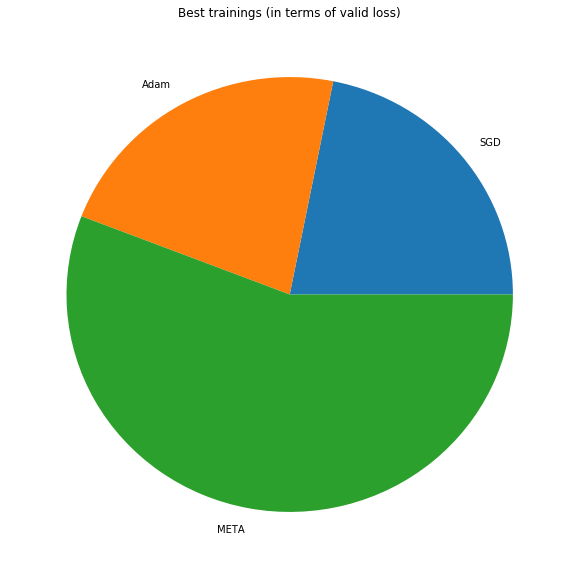

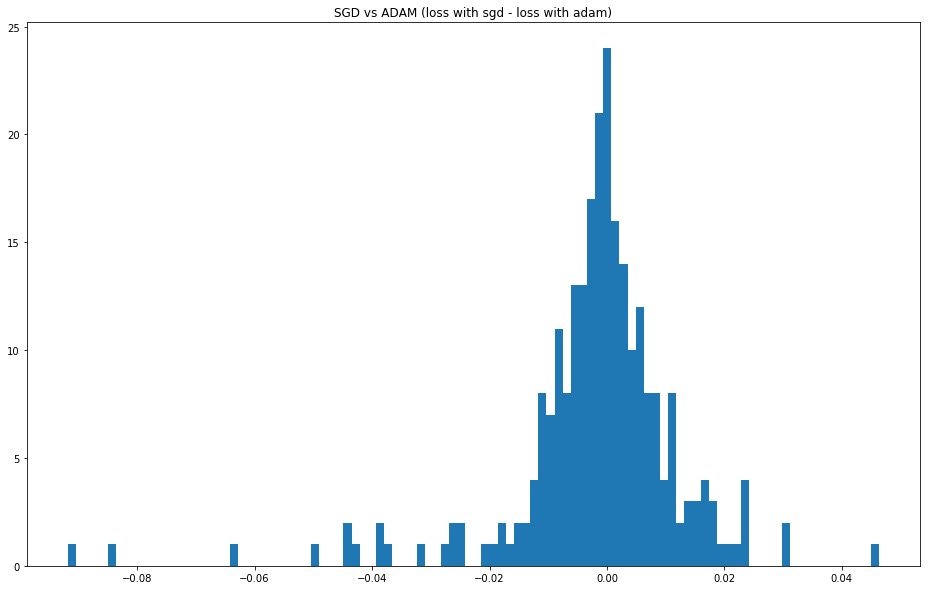

SGD was worse than ADAM in 46.484375% trainings


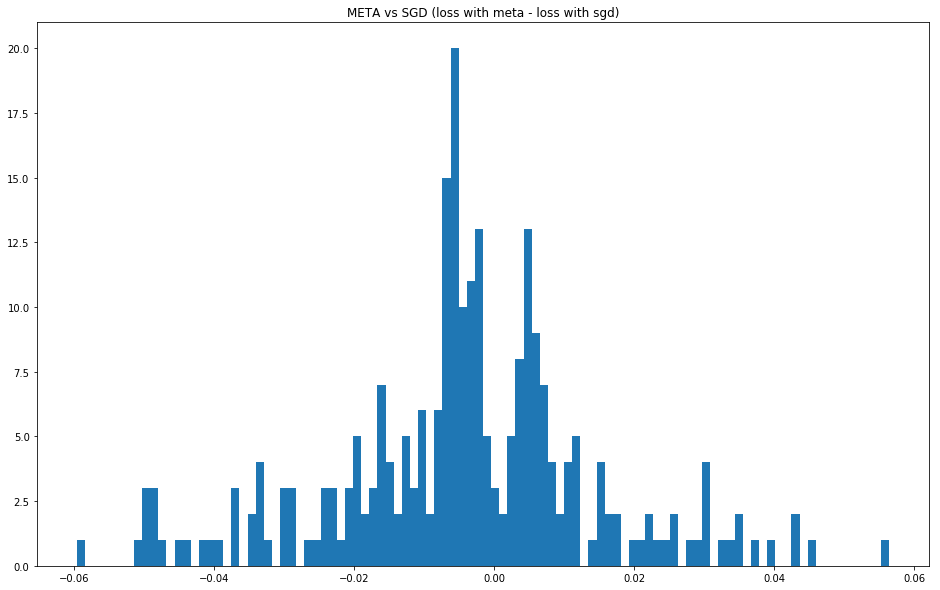

META was worse than SGD in 36.71875% trainings


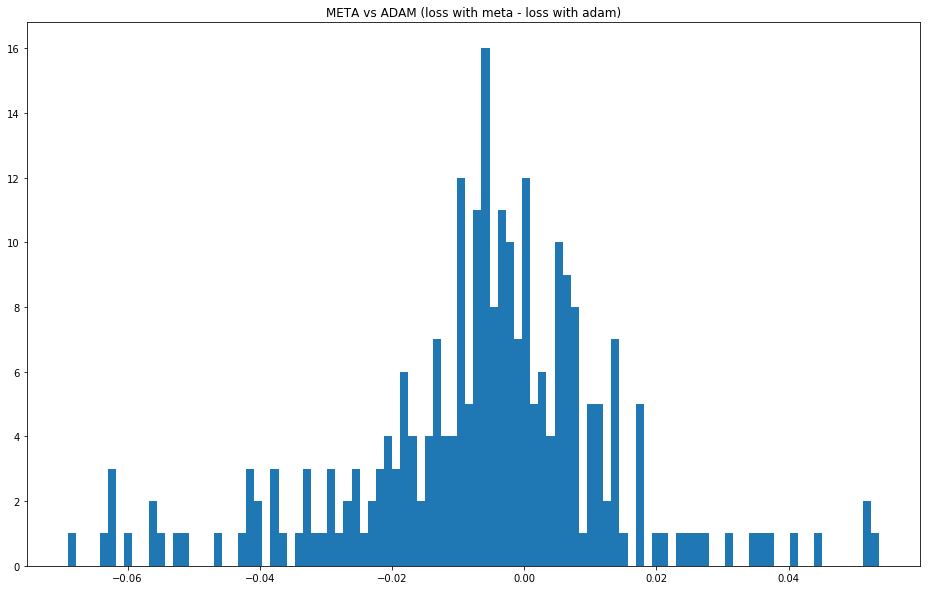

META was worse than ADAM in 36.328125% trainings


In [7]:
import matplotlib.pyplot as plt
import numpy as np

comparison_results = [np.array(r) for r in comparison_results]
best_sgd, best_meta, best_adam = 0, 0, 0

for i in range(len(comparison_results[0])):
    res = [comparison_results[0][i], comparison_results[1][i], comparison_results[2][i]]
    min_ind = res.index(min(res))
    if min_ind == 0:
        best_meta += 1
    elif min_ind == 1:
        best_sgd += 1
    elif min_ind == 2:
        best_adam += 1
        
denom = 100.0/len(comparison_results[0])
print("SGD was best in {:d} trainings ({:.2f}%)".format(best_sgd, best_sgd * denom))
print("Adam was best in {:d} trainings ({:.2f}%)".format(best_adam, best_adam * denom))
print("META was best in {:d} trainings ({:.2f}%)".format(best_meta, best_meta * denom))

plt.rcParams["figure.figsize"] = (10,10)

plt.pie([best_sgd, best_adam, best_meta], labels=['SGD', 'Adam', 'META'])
plt.title("Best trainings (in terms of valid loss)")
plt.show()

sgd_vs_adam = [sgd - adam for sgd, adam in zip(comparison_results[1], comparison_results[2])]
meta_vs_sgd = [meta - sgd for meta, sgd in zip(comparison_results[0], comparison_results[1])]
meta_vs_adam = [meta - adam for meta, adam in zip(comparison_results[0], comparison_results[2])]

plt.rcParams["figure.figsize"] = (16,10)

plt.hist(sgd_vs_adam, bins=100)
plt.title("SGD vs ADAM (loss with sgd - loss with adam)")
plt.show()

worse_count = sum(1 if s > 0 else 0 for s in sgd_vs_adam)
worse_percent = worse_count / len(sgd_vs_adam) * 100
print("SGD was worse than ADAM in {}% trainings".format(worse_percent))

plt.hist(meta_vs_sgd, bins=100)
plt.title("META vs SGD (loss with meta - loss with sgd)")
plt.show()

worse_count = sum(1 if s > 0 else 0 for s in meta_vs_sgd)
worse_percent = worse_count / len(meta_vs_sgd) * 100
print("META was worse than SGD in {}% trainings".format(worse_percent))

plt.hist(meta_vs_adam, bins=100)
plt.title("META vs ADAM (loss with meta - loss with adam)")
plt.show()

worse_count = sum(1 if s > 0 else 0 for s in meta_vs_adam)
worse_percent = worse_count / len(meta_vs_adam) * 100
print("META was worse than ADAM in {}% trainings".format(worse_percent))